In [1]:
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import numpy as np
import pandas as pd

import json
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Define the tutor classes
TUTOR_CLASSES = [
    "Expert",
    "Novice",
    "Gemini",
    "GPT4",
    "Llama31405B",
    "Llama318B",
    "Mistral",
    "Phi3",
    "Sonnet"
]

# Create label mappings
id2label = {i: label for i, label in enumerate(TUTOR_CLASSES)}
label2id = {v: k for k, v in id2label.items()}
print(id2label, label2id)

{0: 'Expert', 1: 'Novice', 2: 'Gemini', 3: 'GPT4', 4: 'Llama31405B', 5: 'Llama318B', 6: 'Mistral', 7: 'Phi3', 8: 'Sonnet'} {'Expert': 0, 'Novice': 1, 'Gemini': 2, 'GPT4': 3, 'Llama31405B': 4, 'Llama318B': 5, 'Mistral': 6, 'Phi3': 7, 'Sonnet': 8}


In [3]:

# Data Processing Functions
def load_data(dev_data_path='///mnt/c/Personal/Competitions/BEA_2025/data/mrbench_v3_devset.json'):
    """
    Load development and (optionally) test datasets
    """
    # Load development data
    with open(dev_data_path, 'r') as f:
        dev_data = json.load(f)
    
    # Process development data
    dev_examples = []
    for dialogue in dev_data:
        conversation_id = dialogue["conversation_id"]
        conversation_history = dialogue["conversation_history"]
        
        for tutor_id, tutor_data in dialogue["tutor_responses"].items():
            if tutor_id in TUTOR_CLASSES or any(cls_name in tutor_id for cls_name in TUTOR_CLASSES):
                # Map the tutor_id to one of our classes
                tutor_class = next((cls for cls in TUTOR_CLASSES if cls in tutor_id), tutor_id)
                
                dev_examples.append({
                    "conversation_id": conversation_id,
                    "conversation_history": conversation_history,
                    "tutor_response": tutor_data["response"],
                    "tutor_class": tutor_class
                })
    

    return dev_examples

In [4]:
import pandas as pd
train = pd.DataFrame(load_data())
train['target'] = train['tutor_class'].map(label2id)
train.rename(columns={'conversation_history':'Question','tutor_response':'Response'},inplace=True)

In [5]:
rows = []
for i, row in train.iterrows():
    question = row.Question
    response = row.Response
    convid = row.conversation_id
    context = train[(train.conversation_id==convid)&(train.Response!=response)].Response.values
    context = '\n'.join(context)
    train.loc[i, 'context'] = context

train['input'] = "Question: " + train['Question'] + '; Answer: ' + train['Response'] + '; Context: ' + train["context"]


In [6]:
fold_map = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/debetav3_context_multisampleDropout/oofs.csv')
train = pd.merge(train,fold_map[['conversation_id','fold','tutor_class']],on=['conversation_id','tutor_class'], how='left')

In [7]:
oof_deberta_large = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/debetav3_context_multisampleDropout/oofs.csv')
oof_deberta_base = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/debetav3_base_context_multisampleDropout/oofs.csv')
oof_longformer_large = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/longformer_base_context_multisampleDropout/oofs.csv')
oof_bigbird_roberta = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/bigbird_roberta_large/oofs.csv')

In [8]:
target_cols = [f'target_{i}' for i in range(len(id2label))]
oof_qwen = fold_map.copy(deep=True)
oof_zephyr = fold_map.copy(deep=True)
for fold in range(5):
    path_qwen =f'///mnt/c/Personal/Competitions/BEA_2025/Qwen25_0.5/outputs/fold{fold}.npy'
    _ = np.load(path_qwen)
    oof_qwen.loc[oof_qwen['fold']==fold,target_cols] = _

    path_zephyr =f'///mnt/c/Personal/Competitions/BEA_2025/Zephyr/outputs/fold{fold}.npy'
    _ = np.load(path_zephyr)
    oof_zephyr.loc[oof_zephyr['fold']==fold,target_cols] = _


In [9]:
test_preds_deberta_large = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/debetav3_context_multisampleDropout/test_probas.csv')
test_preds_deberta_base = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/debetav3_base_context_multisampleDropout/test_probas.csv')
test_preds_longformer_large = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/longformer_base_context_multisampleDropout/test_probas.csv')
test_preds_qwen = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/Qwen25_0.5/outputs/test_probas.csv')
test_preds_zephyr = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/Zephyr/outputs/test_probas.csv')
test_preds_bigbird_roberta = pd.read_csv('///mnt/c/Personal/Competitions/BEA_2025/bigbird_roberta_large/test_probas.csv')


In [10]:
oof_deberta_large.shape, oof_bigbird_roberta.shape, oof_deberta_base.shape, oof_longformer_large.shape, oof_qwen.shape, oof_zephyr.shape

((2476, 17), (2476, 17), (2476, 17), (2476, 17), (2476, 17), (2476, 17))

In [11]:
test_preds_deberta_large.shape, test_preds_bigbird_roberta.shape, test_preds_deberta_base.shape, test_preds_longformer_large.shape, test_preds_qwen.shape, test_preds_zephyr.shape

((1547, 15), (1547, 15), (1547, 15), (1547, 15), (1547, 16), (1547, 15))

In [12]:
test_preds_qwen.head(1)

,conversation_id,Question,Response,tutor_id,context,input,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,pred
0,1030-adb61831-0383-4e51-a673-ab978590f69b,"Tutor: Hi, could you please provide a step-by-...",It looks like you've done a great job figuring...,Tutor_1,"You've done a great job, but there's a small m...","Question: Tutor: Hi, could you please provide ...",0.000037,5.379856e-07,0.983077,0.000003,0.000006,0.000004,0.016387,0.000003,0.000482,2


In [13]:
for c in target_cols:
    oof_deberta_base.rename(columns={c:f'{c}_deberta_base'},inplace=True)
    oof_deberta_large.rename(columns={c:f'{c}_deberta_large'},inplace=True)
    oof_longformer_large.rename(columns={c:f'{c}_longformer_large'},inplace=True)
    oof_bigbird_roberta.rename(columns={c:f'{c}_bigbird_roberta'},inplace=True)
    oof_qwen.rename(columns={c:f'{c}_qwen'},inplace=True)
    oof_zephyr.rename(columns={c:f'{c}_zephyr'},inplace=True)

In [14]:
for c in target_cols:
    test_preds_deberta_base.rename(columns={c:f'{c}_deberta_base'},inplace=True)
    test_preds_deberta_large.rename(columns={c:f'{c}_deberta_large'},inplace=True)      
    test_preds_longformer_large.rename(columns={c:f'{c}_longformer_large'},inplace=True)
    test_preds_bigbird_roberta.rename(columns={c:f'{c}_bigbird_roberta'},inplace=True)
    test_preds_qwen.rename(columns={c:f'{c}_qwen'},inplace=True)
    test_preds_zephyr.rename(columns={c:f'{c}_zephyr'},inplace=True)
    

In [15]:
train.head(1)

,conversation_id,Question,Response,tutor_class,target,context,input,fold
0,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...","Great, you've correctly identified the cost of...",Sonnet,8,Now that we know the cost of 1 pound of meat i...,"Question: Tutor: Hi, could you please provide ...",0


In [16]:

# Data Processing Functions
def load_test_data(test_data_path='///mnt/c/Personal/Competitions/BEA_2025/data/mrbench_v3_testset.json'):
    """
    Load development and (optionally) test datasets
    """    
    # Load test data if provided
    test_examples = []
    test_data = None
    if test_data_path:
        with open(test_data_path, 'r',encoding="utf-8") as f:
            test_data = json.load(f)
        
        for dialogue in test_data:
            conversation_id = dialogue["conversation_id"]
            conversation_history = dialogue["conversation_history"]
            
            for tutor_id, tutor_data in dialogue["tutor_responses"].items():
                test_examples.append({
                    "conversation_id": conversation_id,
                    "conversation_history": conversation_history,
                    "tutor_response": tutor_data["response"],
                    "tutor_id": tutor_id
                })
    
    return test_examples, test_data

test_examples,test_data = load_test_data()
test = pd.DataFrame(test_examples)
test.rename(columns={'conversation_history':'Question','tutor_response':'Response'},inplace=True)
for i, row in test.iterrows():
    question = row.Question
    response = row.Response
    convid = row.conversation_id
    context = test[(test.conversation_id==convid)&(test.Response!=response)].Response.values
    context = '\n'.join(context)
    test.loc[i, 'context'] = context

test['input'] = "Question: " + test['Question'] + '; Answer: ' + test['Response'] + '; Context: ' + test["context"]


In [17]:
test.head(1)

,conversation_id,Question,Response,tutor_id,context,input
0,1030-adb61831-0383-4e51-a673-ab978590f69b,"Tutor: Hi, could you please provide a step-by-...",It looks like you've done a great job figuring...,Tutor_1,"You've done a great job, but there's a small m...","Question: Tutor: Hi, could you please provide ..."


In [18]:
train.head(1)

,conversation_id,Question,Response,tutor_class,target,context,input,fold
0,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Tutor: Hi, could you please provide a step-by-...","Great, you've correctly identified the cost of...",Sonnet,8,Now that we know the cost of 1 pound of meat i...,"Question: Tutor: Hi, could you please provide ...",0


In [19]:
test_df = test[['conversation_id','input']]
train_df = train[['conversation_id','input','fold','target']]
test_df.head(1)
train_df.head(1)

,conversation_id,input,fold,target
0,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Question: Tutor: Hi, could you please provide ...",0,8


In [20]:
test_df = pd.concat([test_df,test_preds_deberta_base[[f'target_{i}_deberta_base' for i in range(len(id2label))]]],axis=1)
test_df = pd.concat([test_df,test_preds_deberta_large[[f'target_{i}_deberta_large' for i in range(len(id2label))]]],axis=1)
test_df = pd.concat([test_df,test_preds_longformer_large[[f'target_{i}_longformer_large' for i in range(len(id2label))]]],axis=1)
test_df = pd.concat([test_df,test_preds_bigbird_roberta[[f'target_{i}_bigbird_roberta' for i in range(len(id2label))]]],axis=1)
test_df = pd.concat([test_df,test_preds_qwen[[f'target_{i}_qwen' for i in range(len(id2label))]]],axis=1)
test_df = pd.concat([test_df,test_preds_zephyr[[f'target_{i}_zephyr' for i in range(len(id2label))]]],axis=1)
print(test_df.head(1))
    

                             conversation_id  \
0  1030-adb61831-0383-4e51-a673-ab978590f69b   

                                               input  target_0_deberta_base  \
0  Question: Tutor: Hi, could you please provide ...               0.005174   

   target_1_deberta_base  target_2_deberta_base  target_3_deberta_base  \
0               0.001483               0.925089               0.008375   

   target_4_deberta_base  target_5_deberta_base  target_6_deberta_base  \
0               0.006387               0.013104               0.021824   

   target_7_deberta_base  ...  target_8_qwen  target_0_zephyr  \
0               0.011598  ...       0.000482              0.0   

   target_1_zephyr  target_2_zephyr  target_3_zephyr  target_4_zephyr  \
0              0.0              1.0              0.0              0.0   

   target_5_zephyr  target_6_zephyr  target_7_zephyr  target_8_zephyr  
0              0.0         0.000118              0.0              0.0  

[1 rows x 56 columns]


In [21]:
test_df.columns

Index(['conversation_id', 'input', 'target_0_deberta_base',
       'target_1_deberta_base', 'target_2_deberta_base',
       'target_3_deberta_base', 'target_4_deberta_base',
       'target_5_deberta_base', 'target_6_deberta_base',
       'target_7_deberta_base', 'target_8_deberta_base',
       'target_0_deberta_large', 'target_1_deberta_large',
       'target_2_deberta_large', 'target_3_deberta_large',
       'target_4_deberta_large', 'target_5_deberta_large',
       'target_6_deberta_large', 'target_7_deberta_large',
       'target_8_deberta_large', 'target_0_longformer_large',
       'target_1_longformer_large', 'target_2_longformer_large',
       'target_3_longformer_large', 'target_4_longformer_large',
       'target_5_longformer_large', 'target_6_longformer_large',
       'target_7_longformer_large', 'target_8_longformer_large',
       'target_0_bigbird_roberta', 'target_1_bigbird_roberta',
       'target_2_bigbird_roberta', 'target_3_bigbird_roberta',
       'target_4_bigbird_rob

In [22]:
train_df = pd.concat([train_df,oof_deberta_base[[f'target_{i}_deberta_base' for i in range(len(id2label))]]],axis=1)
train_df = pd.concat([train_df,oof_deberta_large[[f'target_{i}_deberta_large' for i in range(len(id2label))]]],axis=1)
train_df = pd.concat([train_df,oof_longformer_large[[f'target_{i}_longformer_large' for i in range(len(id2label))]]],axis=1)
train_df = pd.concat([train_df,oof_bigbird_roberta[[f'target_{i}_bigbird_roberta' for i in range(len(id2label))]]],axis=1)
train_df = pd.concat([train_df,oof_qwen[[f'target_{i}_qwen' for i in range(len(id2label))]]],axis=1)
train_df = pd.concat([train_df,oof_zephyr[[f'target_{i}_zephyr' for i in range(len(id2label))]]],axis=1)
print(train_df.head(1))
    

                            conversation_id  \
0  221-362eb11a-f190-42a6-b2a4-985fafdcfa9e   

                                               input  fold  target  \
0  Question: Tutor: Hi, could you please provide ...     0       8   

   target_0_deberta_base  target_1_deberta_base  target_2_deberta_base  \
0               0.009969               0.007904               0.065771   

   target_3_deberta_base  target_4_deberta_base  target_5_deberta_base  ...  \
0               0.022601               0.029983               0.027106  ...   

   target_8_qwen  target_0_zephyr  target_1_zephyr  target_2_zephyr  \
0        0.02591              0.0              0.0              0.0   

   target_3_zephyr  target_4_zephyr  target_5_zephyr  target_6_zephyr  \
0              0.0              0.0         0.000011     5.364418e-07   

   target_7_zephyr  target_8_zephyr  
0     2.980232e-07              1.0  

[1 rows x 58 columns]


In [23]:
train_df.columns

Index(['conversation_id', 'input', 'fold', 'target', 'target_0_deberta_base',
       'target_1_deberta_base', 'target_2_deberta_base',
       'target_3_deberta_base', 'target_4_deberta_base',
       'target_5_deberta_base', 'target_6_deberta_base',
       'target_7_deberta_base', 'target_8_deberta_base',
       'target_0_deberta_large', 'target_1_deberta_large',
       'target_2_deberta_large', 'target_3_deberta_large',
       'target_4_deberta_large', 'target_5_deberta_large',
       'target_6_deberta_large', 'target_7_deberta_large',
       'target_8_deberta_large', 'target_0_longformer_large',
       'target_1_longformer_large', 'target_2_longformer_large',
       'target_3_longformer_large', 'target_4_longformer_large',
       'target_5_longformer_large', 'target_6_longformer_large',
       'target_7_longformer_large', 'target_8_longformer_large',
       'target_0_bigbird_roberta', 'target_1_bigbird_roberta',
       'target_2_bigbird_roberta', 'target_3_bigbird_roberta',
       'ta

In [24]:
#### sklearn tfidf and other NLP features

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

tfidf = TfidfVectorizer(max_features=128,ngram_range=(1,3),analyzer='word',stop_words='english')
# Combine train and test data for fitting the TF-IDF vectorizer
combined_texts = pd.concat([train_df['input'], test_df['input']], axis=0).reset_index(drop=True)

# Fit the TF-IDF vectorizer on all data
tfidf_features = tfidf.fit_transform(combined_texts)

# Split back into train and test
train_tfidf = tfidf_features[:len(train_df)]
test_tfidf = tfidf_features[len(train_df):]

# Convert to DataFrame for easier handling
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=[f'tfidf_{i}' for i in range(train_tfidf.shape[1])])
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=[f'tfidf_{i}' for i in range(test_tfidf.shape[1])])

# Add TF-IDF features to train and test dataframes
train_df = pd.concat([train_df, train_tfidf_df], axis=1)
test_df = pd.concat([test_df, test_tfidf_df], axis=1)

print(f"Added {train_tfidf.shape[1]} TF-IDF features to train and test data")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")


Added 128 TF-IDF features to train and test data
Train shape: (2476, 186), Test shape: (1547, 184)


In [25]:
# Create CountVectorizer features
count_vec = CountVectorizer(max_features=128, ngram_range=(1,3), analyzer='word', stop_words='english')

# Fit the CountVectorizer on all data
count_features = count_vec.fit_transform(combined_texts)

# Split back into train and test
train_count = count_features[:len(train_df)]
test_count = count_features[len(train_df):]

# Convert to DataFrame with distinct column names
train_count_df = pd.DataFrame(train_count.toarray(), columns=[f'count_{i}' for i in range(train_count.shape[1])])
test_count_df = pd.DataFrame(test_count.toarray(), columns=[f'count_{i}' for i in range(test_count.shape[1])])

# Add CountVectorizer features to train and test dataframes
train_df = pd.concat([train_df, train_count_df], axis=1)
test_df = pd.concat([test_df, test_count_df], axis=1)

print(f"Added {train_count.shape[1]} CountVectorizer features to train and test data")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")


Added 128 CountVectorizer features to train and test data
Train shape: (2476, 314), Test shape: (1547, 312)


In [26]:
# Create additional NLP features
import re
print("Creating additional NLP features...")

# Function to extract text features
def extract_text_features(texts):
    features = pd.DataFrame()
    
    # Basic count features
    features['word_count'] = texts.apply(lambda x: len(str(x).split()))
    features['char_count'] = texts.apply(lambda x: len(str(x)))
    features['sentence_count'] = texts.apply(lambda x: len(str(x).split('.')))
    features['avg_word_length'] = texts.apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
    
    # Case features
    features['uppercase_count'] = texts.apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    features['lowercase_count'] = texts.apply(lambda x: sum(1 for c in str(x) if c.islower()))
    features['uppercase_word_count'] = texts.apply(lambda x: sum(1 for w in str(x).split() if w.isupper()))
    features['title_word_count'] = texts.apply(lambda x: sum(1 for w in str(x).split() if w.istitle()))
    
    # Punctuation features
    features['question_mark_count'] = texts.apply(lambda x: str(x).count('?'))
    features['exclamation_mark_count'] = texts.apply(lambda x: str(x).count('!'))
    features['comma_count'] = texts.apply(lambda x: str(x).count(','))
    features['period_count'] = texts.apply(lambda x: str(x).count('.'))
    features['colon_count'] = texts.apply(lambda x: str(x).count(':'))
    features['semicolon_count'] = texts.apply(lambda x: str(x).count(';'))
    features['quote_count'] = texts.apply(lambda x: str(x).count('"') + str(x).count("'"))
    
    # Math-specific features
    features['plus_count'] = texts.apply(lambda x: str(x).count('+'))
    features['minus_count'] = texts.apply(lambda x: str(x).count('-'))
    features['multiply_count'] = texts.apply(lambda x: str(x).count('*'))
    features['divide_count'] = texts.apply(lambda x: str(x).count('/'))
    features['equal_count'] = texts.apply(lambda x: str(x).count('='))
    features['number_count'] = texts.apply(lambda x: sum(c.isdigit() for c in str(x)))
    features['math_symbol_count'] = features['plus_count'] + features['minus_count'] + features['multiply_count'] + features['divide_count'] + features['equal_count']
    
    # Fraction pattern (e.g., 1/2, 3/4)
    features['fraction_pattern_count'] = texts.apply(lambda x: len(re.findall(r'\d+/\d+', str(x))))
    
    # Parentheses and brackets (often used in math)
    features['parentheses_count'] = texts.apply(lambda x: str(x).count('(') + str(x).count(')'))
    features['bracket_count'] = texts.apply(lambda x: str(x).count('[') + str(x).count(']'))
    
    
    # Chat/conversation features
    features['tutor_mention_count'] = texts.apply(lambda x: str(x).lower().count('tutor'))
    features['student_mention_count'] = texts.apply(lambda x: str(x).lower().count('student'))
    features['question_word_count'] = texts.apply(lambda x: sum(1 for w in str(x).lower().split() if w in ['what', 'why', 'how', 'when', 'where', 'who', 'which']))
    
    # Ratios and proportions
    features['question_to_sentence_ratio'] = features['question_mark_count'] / features['sentence_count'].replace(0, 1)
    features['uppercase_ratio'] = features['uppercase_count'] / features['char_count'].replace(0, 1)
    features['math_symbol_to_word_ratio'] = features['math_symbol_count'] / features['word_count'].replace(0, 1)
    
    return features

# Extract features from train and test data
train_text_features = extract_text_features(train_df['input'])
test_text_features = extract_text_features(test_df['input'])

# Add text features to train and test dataframes
train_df = pd.concat([train_df, train_text_features], axis=1)
test_df = pd.concat([test_df, test_text_features], axis=1)

print(f"Added {train_text_features.shape[1]} additional text features to train and test data")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")


Creating additional NLP features...
Added 31 additional text features to train and test data
Train shape: (2476, 345), Test shape: (1547, 343)


In [27]:
# Check for constant features in train_df
constant_features_train = [col for col in train_df.columns if train_df[col].nunique() == 1]
if constant_features_train:
    print(f"Constant features in train data: {constant_features_train}")
    print(f"Values: {[train_df[col].iloc[0] for col in constant_features_train]}")
    
# Check for constant features in test_df
constant_features_test = [col for col in test_df.columns if test_df[col].nunique() == 1]
if constant_features_test:
    print(f"Constant features in test data: {constant_features_test}")
    print(f"Values: {[test_df[col].iloc[0] for col in constant_features_test]}")

# Combine constant features from both datasets
all_constant_features = list(set(constant_features_train + constant_features_test))
if all_constant_features:
    print(f"Dropping {len(all_constant_features)} constant features...")
    train_df = train_df.drop(columns=all_constant_features)
    test_df = test_df.drop(columns=all_constant_features)
    print(f"New train shape: {train_df.shape}, New test shape: {test_df.shape}")
else:
    print("No constant features found in the datasets.")


No constant features found in the datasets.


In [28]:
train_df.head(1)

,conversation_id,input,fold,target,target_0_deberta_base,target_1_deberta_base,target_2_deberta_base,target_3_deberta_base,target_4_deberta_base,target_5_deberta_base,...,math_symbol_count,fraction_pattern_count,parentheses_count,bracket_count,tutor_mention_count,student_mention_count,question_word_count,question_to_sentence_ratio,uppercase_ratio,math_symbol_to_word_ratio
0,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,"Question: Tutor: Hi, could you please provide ...",0,8,0.009969,0.007904,0.065771,0.022601,0.029983,0.027106,...,13,1,2,0,4,4,6,0.233333,0.016849,0.028953


In [30]:
train_df['target'].value_counts()

target
8    300
5    300
4    300
3    300
6    300
0    300
2    300
7    300
1     76
Name: count, dtype: int64

Training LightGBM with 5-fold cross-validation using best parameters


  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.713808	valid_1's multi_logloss: 0.781452
[100]	training's multi_logloss: 0.367832	valid_1's multi_logloss: 0.454692
[150]	training's multi_logloss: 0.237037	valid_1's multi_logloss: 0.347998
[200]	training's multi_logloss: 0.168734	valid_1's multi_logloss: 0.318686
[250]	training's multi_logloss: 0.118455	valid_1's multi_logloss: 0.31437


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

Early stopping, best iteration is:
[239]	training's multi_logloss: 0.129312	valid_1's multi_logloss: 0.31303
Fold 0: Accuracy = 0.9049, F1 = 0.9040, Log Loss = 0.3130
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.714673	valid_1's multi_logloss: 0.742886
[100]	training's multi_logloss: 0.37268	valid_1's multi_logloss: 0.4216
[150]	training's multi_logloss: 0.241937	valid_1's multi_logloss: 0.314749
[200]	training's multi_logloss: 0.174431	valid_1's multi_logloss: 0.283536
[250]	training's multi_logloss: 0.120694	valid_1's multi_logloss: 0.277807


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Early stopping, best iteration is:
[243]	training's multi_logloss: 0.127768	valid_1's multi_logloss: 0.277162
Fold 1: Accuracy = 0.9089, F1 = 0.9171, Log Loss = 0.2772
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.716743	valid_1's multi_logloss: 0.7583
[100]	training's multi_logloss: 0.372794	valid_1's multi_logloss: 0.428607
[150]	training's multi_logloss: 0.244348	valid_1's multi_logloss: 0.318932
[200]	training's multi_logloss: 0.174334	valid_1's multi_logloss: 0.282685
[250]	training's multi_logloss: 0.122466	valid_1's multi_logloss: 0.269882
[300]	training's multi_logloss: 0.0857369	valid_1's multi_logloss: 0.265885


 60%|██████    | 3/5 [00:13<00:09,  4.70s/it]

[350]	training's multi_logloss: 0.0573058	valid_1's multi_logloss: 0.270352
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.0807813	valid_1's multi_logloss: 0.26582
Fold 2: Accuracy = 0.9215, F1 = 0.9274, Log Loss = 0.2658
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.725661	valid_1's multi_logloss: 0.733964
[100]	training's multi_logloss: 0.380953	valid_1's multi_logloss: 0.396409
[150]	training's multi_logloss: 0.250825	valid_1's multi_logloss: 0.285439
[200]	training's multi_logloss: 0.182009	valid_1's multi_logloss: 0.249936
[250]	training's multi_logloss: 0.130658	valid_1's multi_logloss: 0.236945
[300]	training's multi_logloss: 0.0911416	valid_1's multi_logloss: 0.238437
Early stopping, best iteration is:
[263]	training's multi_logloss: 0.119168	valid_1's multi_logloss: 0.235025


 80%|████████  | 4/5 [00:17<00:04,  4.35s/it]

Fold 3: Accuracy = 0.9394, F1 = 0.9442, Log Loss = 0.2350
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.715252	valid_1's multi_logloss: 0.747129
[100]	training's multi_logloss: 0.373821	valid_1's multi_logloss: 0.415019
[150]	training's multi_logloss: 0.245366	valid_1's multi_logloss: 0.302061
[200]	training's multi_logloss: 0.177686	valid_1's multi_logloss: 0.260226
[250]	training's multi_logloss: 0.127762	valid_1's multi_logloss: 0.242569
[300]	training's multi_logloss: 0.0862429	valid_1's multi_logloss: 0.236403
[350]	training's multi_logloss: 0.0575355	valid_1's multi_logloss: 0.235083


100%|██████████| 5/5 [00:22<00:00,  4.48s/it]

[400]	training's multi_logloss: 0.0388169	valid_1's multi_logloss: 0.239381
Early stopping, best iteration is:
[352]	training's multi_logloss: 0.0565713	valid_1's multi_logloss: 0.234964
Fold 4: Accuracy = 0.9113, F1 = 0.9192, Log Loss = 0.2350

Overall OOF: Accuracy = 0.9172, F1 = 0.9226, Log Loss = 0.2652


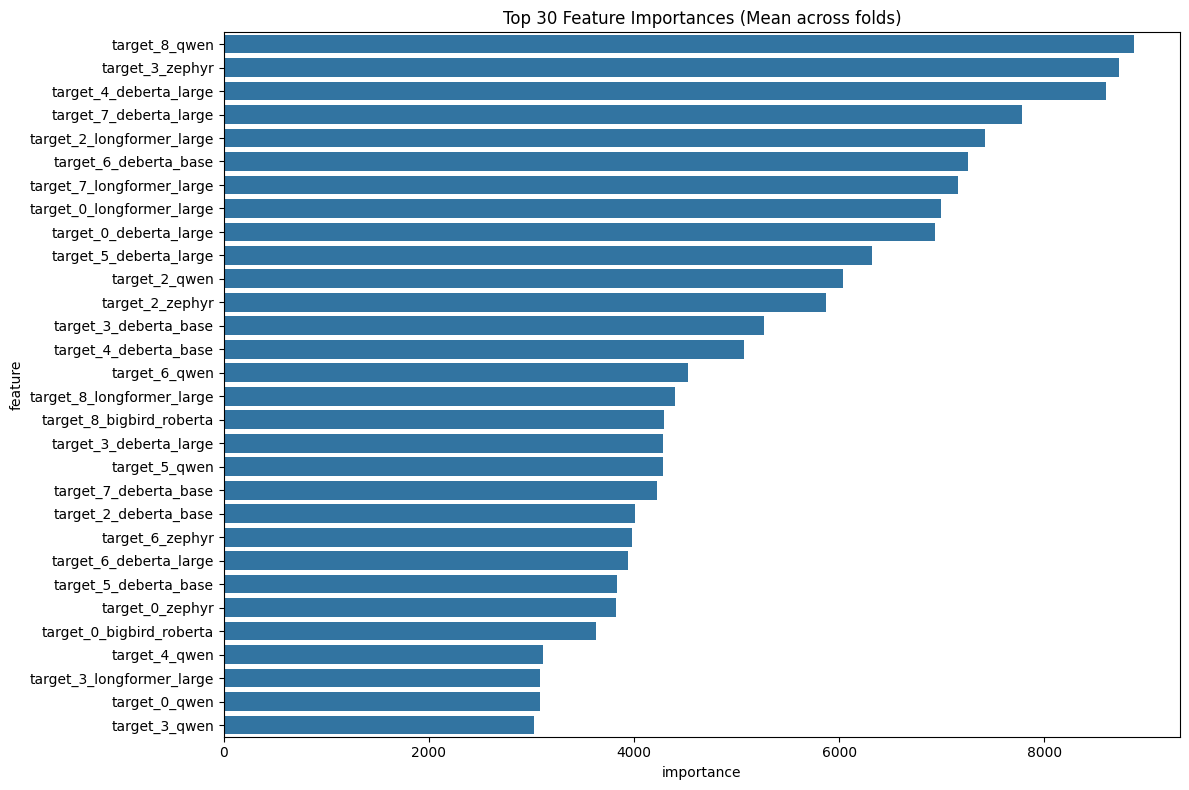

Training and prediction completed!


In [31]:
# Get feature columns (exclude non-feature columns)
from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


exclude_cols = ['conversation_id', 'input', 'fold', 'target']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# Initialize arrays for OOF predictions and test predictions
oof_preds = np.zeros((len(train_df), 9))
test_preds = np.zeros((len(test_df), 9))

# Store feature importances
feature_importance_df = pd.DataFrame()

# K-fold training and prediction with best parameters
n_folds = train_df['fold'].nunique()
print(f"Training LightGBM with {n_folds}-fold cross-validation using best parameters")

for fold in tqdm(range(n_folds)):
    # Split data
    train_idx = train_df[train_df['fold'] != fold].index
    valid_idx = train_df[train_df['fold'] == fold].index
    
    X_train, y_train = train_df.loc[train_idx, feature_cols], train_df.loc[train_idx, 'target']
    X_valid, y_valid = train_df.loc[valid_idx, feature_cols], train_df.loc[valid_idx, 'target']
    
    # Create LightGBM datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
    best_params = {'boosting_type': 'gbdt', 
                   'learning_rate': 0.012487824960194313, 
                   'num_leaves': 33, 
                   'max_depth': 14, 
                   'min_data_in_leaf': 76, 
                   'feature_fraction': 0.5244876442319142, 
                   'bagging_fraction': 0.6309068312529033,
                    'bagging_freq': 8,}
    best_params.update({
    'objective': 'multiclass',
    'num_class': 9,
    'metric': 'multi_logloss',
    'verbose': -1,
})
    # Train model with best parameters
    model = lgb.train(
        params=best_params,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                  lgb.log_evaluation(period=50)])
    # OOF predictions
    oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
    
    # Test predictions (average across folds)
    test_preds += model.predict(test_df[feature_cols], num_iteration=model.best_iteration) / n_folds
    
    # Feature importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_cols
    fold_importance["importance"] = model.feature_importance(importance_type='gain')
    fold_importance["fold"] = fold
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)
    
    # Print fold metrics
    oof_fold_preds = np.argmax(oof_preds[valid_idx], axis=1)
    fold_acc = accuracy_score(y_valid, oof_fold_preds)
    fold_f1 = f1_score(y_valid, oof_fold_preds, average='macro')
    fold_loss = log_loss(y_valid, oof_preds[valid_idx])
    print(f"Fold {fold}: Accuracy = {fold_acc:.4f}, F1 = {fold_f1:.4f}, Log Loss = {fold_loss:.4f}")

# Overall OOF metrics
oof_preds_class = np.argmax(oof_preds, axis=1)
oof_acc = accuracy_score(train_df['target'], oof_preds_class)
oof_f1 = f1_score(train_df['target'], oof_preds_class, average='macro')
oof_loss = log_loss(train_df['target'], oof_preds)
print(f"\nOverall OOF: Accuracy = {oof_acc:.4f}, F1 = {oof_f1:.4f}, Log Loss = {oof_loss:.4f}")

# Convert test predictions to class labels
test_preds_class = np.argmax(test_preds, axis=1)

# Add predictions to test dataframe
test_df['predicted_target'] = test_preds_class
for i in range(best_params['num_class']):
    test_df[f'prob_class_{i}'] = test_preds[:, i]

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
top_features = feature_importance.head(30).index
sns.barplot(x=feature_importance[top_features], y=top_features)
plt.title('Top 30 Feature Importances (Mean across folds)')
plt.tight_layout()
plt.show()

print("Training and prediction completed!")


In [32]:
# Create a list of probability columns
prob_columns = [f'prob_class_{i}' for i in range(9)]
prob_columns.append('conversation_id')
# Check if these columns exist in the dataframe
print(prob_columns)
# Display the probability columns from the dataframe
test_df[prob_columns].head()

['prob_class_0', 'prob_class_1', 'prob_class_2', 'prob_class_3', 'prob_class_4', 'prob_class_5', 'prob_class_6', 'prob_class_7', 'prob_class_8', 'conversation_id']


,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,conversation_id
0,0.002117,0.000401,0.968376,0.002055,0.002452,0.003208,0.015544,0.001634,0.004213,1030-adb61831-0383-4e51-a673-ab978590f69b
1,0.000762,0.000194,0.000828,0.993134,0.001054,0.001307,0.000906,0.000971,0.000843,1030-adb61831-0383-4e51-a673-ab978590f69b
2,0.969887,0.000310,0.001629,0.002618,0.002472,0.005601,0.008811,0.007207,0.001465,1030-adb61831-0383-4e51-a673-ab978590f69b
3,0.001630,0.000426,0.001804,0.002565,0.977819,0.010538,0.001799,0.001696,0.001721,1030-adb61831-0383-4e51-a673-ab978590f69b
4,0.001781,0.000189,0.000810,0.001076,0.000925,0.001463,0.001582,0.990992,0.001182,1030-adb61831-0383-4e51-a673-ab978590f69b


In [33]:
def assign_unique_classes(df):
    """
    Assigns unique classes to rows within each conversation group,
    resolving conflicts by picking highest probability instances.
    
    Args:
        df: Dataframe with conversation_id and probability columns (prob_class_0 through prob_class_8)
        
    Returns:
        Dataframe with added columns for predicted class and updated prediction
    """
    # Create a copy to avoid modifying the original dataframe
    result_df = df.copy()
    
    # Add columns for original prediction (argmax) and final prediction
    prob_cols = [f'prob_class_{i}' for i in range(9)]
    result_df['original_pred'] = result_df[prob_cols].values.argmax(axis=1)
    result_df['final_pred'] = -1  # Initialize with placeholder
    
    # Process each conversation group
    for conv_id, group in result_df.groupby('conversation_id'):
        # Get the indices for this group in the original dataframe
        group_indices = group.index
        
        # Extract probability matrix for this group
        probs = group[prob_cols].values
        
        # Track assigned classes to avoid repeats
        assigned_classes = set()
        
        # Process rows in order of maximum probability confidence
        # This ensures rows with highest confidence get priority
        row_max_probs = probs.max(axis=1)
        row_order = np.argsort(-row_max_probs)  # Sort by descending max probability
        
        for row_idx in row_order:
            orig_idx = group_indices[row_idx]
            
            # Create a masked version of probabilities for this row
            # Mask already assigned classes with -1 to exclude them
            row_probs = probs[row_idx].copy()
            for assigned_class in assigned_classes:
                row_probs[assigned_class] = -1
                
            # Get the best remaining class
            if row_probs.max() > -1:  # Check if we have valid classes left
                best_class = row_probs.argmax()
                assigned_classes.add(best_class)
                result_df.at[orig_idx, 'final_pred'] = best_class
            else:
                # This should rarely happen if number of rows ≤ number of classes
                # But handling edge case where we run out of classes
                result_df.at[orig_idx, 'final_pred'] = -999  # Error code
    
    return result_df

test_df = assign_unique_classes(test_df)


In [34]:
# Create a pseudo-train dataset from high-confidence predictions
# Get the maximum probability for each row
th = 0.85
test_df['max_prob'] = test_df[[f'prob_class_{i}' for i in range(9)]].max(axis=1)

# Filter rows with >95% confidence
high_confidence_df = test_df[test_df['max_prob'] > th].copy()

# Display information about the high confidence dataset
print(f"Total test samples: {len(test_df)}")
print(f"High confidence samples ({th*100}%): {len(high_confidence_df)}")
print(f"Percentage of high confidence samples: {len(high_confidence_df)/len(test_df)*100:.2f}%")

# Distribution of classes in high confidence samples
print("\nClass distribution in high confidence samples:")
class_distribution = high_confidence_df['final_pred'].value_counts().sort_index()
for class_idx, count in class_distribution.items():
    print(f"Class {class_idx}: {count} samples ({count/len(high_confidence_df)*100:.2f}%)")

# Create the pseudo-train dataset with relevant features
pseudo_train = high_confidence_df.copy()
pseudo_train['pseudo_label'] = pseudo_train['final_pred']  # Use final_pred as the label

# Display the first few rows of the pseudo-train dataset
print("\nPseudo-train dataset sample:")
pseudo_train.head()


Total test samples: 1547
High confidence samples (85.0%): 1126
Percentage of high confidence samples: 72.79%

Class distribution in high confidence samples:
Class 0: 181 samples (16.07%)
Class 1: 15 samples (1.33%)
Class 2: 124 samples (11.01%)
Class 3: 142 samples (12.61%)
Class 4: 125 samples (11.10%)
Class 5: 84 samples (7.46%)
Class 6: 136 samples (12.08%)
Class 7: 177 samples (15.72%)
Class 8: 142 samples (12.61%)

Pseudo-train dataset sample:


,conversation_id,input,target_0_deberta_base,target_1_deberta_base,target_2_deberta_base,target_3_deberta_base,target_4_deberta_base,target_5_deberta_base,target_6_deberta_base,target_7_deberta_base,...,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,original_pred,final_pred,max_prob,pseudo_label
0,1030-adb61831-0383-4e51-a673-ab978590f69b,"Question: Tutor: Hi, could you please provide ...",0.005174,0.001483,0.925089,0.008375,0.006387,0.013104,0.021824,0.011598,...,0.002055,0.002452,0.003208,0.015544,0.001634,0.004213,2,2,0.968376,2
1,1030-adb61831-0383-4e51-a673-ab978590f69b,"Question: Tutor: Hi, could you please provide ...",0.005118,0.001437,0.005278,0.958946,0.004202,0.009362,0.005535,0.005198,...,0.993134,0.001054,0.001307,0.000906,0.000971,0.000843,3,3,0.993134,3
2,1030-adb61831-0383-4e51-a673-ab978590f69b,"Question: Tutor: Hi, could you please provide ...",0.963293,0.000846,0.004049,0.003732,0.003101,0.007229,0.006564,0.005012,...,0.002618,0.002472,0.005601,0.008811,0.007207,0.001465,0,0,0.969887,0
3,1030-adb61831-0383-4e51-a673-ab978590f69b,"Question: Tutor: Hi, could you please provide ...",0.003281,0.002466,0.004598,0.004965,0.955541,0.009210,0.004848,0.007917,...,0.002565,0.977819,0.010538,0.001799,0.001696,0.001721,4,4,0.977819,4
4,1030-adb61831-0383-4e51-a673-ab978590f69b,"Question: Tutor: Hi, could you please provide ...",0.004487,0.001878,0.011213,0.006288,0.008378,0.014966,0.009138,0.935173,...,0.001076,0.000925,0.001463,0.001582,0.990992,0.001182,7,7,0.990992,7


In [35]:
oof_preds_df = pd.DataFrame(oof_preds)
oof_preds_df.head()
oof_preds_df.columns = [f'prob_class_{i}' for i in range(oof_preds_df.shape[1])]
oof_preds_df['predicted_target_initial'] = np.argmax(oof_preds_df.values, axis=1)
oof_preds_df['conversation_id'] = train['conversation_id']
oof_preds_df['actual_target'] = train['target']
oof_preds_df.head()

oof_preds_df =  assign_unique_classes(oof_preds_df)
oof_preds_df.head()


,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,predicted_target_initial,conversation_id,actual_target,original_pred,final_pred
0,0.006715,0.002367,0.008994,0.008443,0.019730,0.143452,0.261919,0.007635,0.540746,8,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,8,8,8
1,0.003172,0.000903,0.003340,0.003708,0.055587,0.920395,0.004211,0.003294,0.005389,5,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,5,5,5
2,0.002633,0.000746,0.002754,0.003220,0.944564,0.036840,0.003143,0.002852,0.003247,4,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,4,4,4
3,0.005231,0.000731,0.002710,0.967511,0.004289,0.007442,0.003832,0.004474,0.003780,3,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,3,3,3
4,0.001241,0.000346,0.001653,0.001465,0.001536,0.001661,0.989011,0.001579,0.001508,6,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,6,6,6


In [36]:
# Add high confidence samples to training data
print("Adding high confidence samples to training data...")

# Create a copy of the high confidence samples for training
pseudo_train_for_merge = high_confidence_df.copy()
pseudo_train_for_merge['fold'] = -1  # Mark as special fold so they're only used for training
pseudo_train_for_merge['target'] = pseudo_train_for_merge['final_pred']  # Use final_pred as the target
pseudo_train_for_merge = pseudo_train_for_merge[train_df.columns]
# Combine original training data with pseudo-labeled data
combined_train = pd.concat([train_df, pseudo_train_for_merge], ignore_index=True)

print(f"Original training samples: {len(train)}")
print(f"Added high confidence samples: {len(pseudo_train_for_merge)}")
print(f"Total combined training samples: {len(combined_train)}")

# Display class distribution in the combined dataset
print("\nClass distribution in combined training dataset:")
combined_class_dist = combined_train['target'].value_counts().sort_index()
for class_idx, count in combined_class_dist.items():
    print(f"Class {class_idx}: {count} samples ({count/len(combined_train)*100:.2f}%)")

# Train a new model with the combined dataset
print("\nTraining new model with combined dataset...")

# Initialize arrays for OOF predictions
oof_preds_combined = np.zeros((len(train_df), 9))
test_preds_combined = np.zeros((len(test_df), 9))

# Train and evaluate the model with the combined dataset
for fold in range(5):
    print(f"\nFold {fold}")
    
    # Get training and validation indices
    # Note: high confidence samples (fold=-1) will only be in training
    train_idx = combined_train[combined_train['fold'] != fold].index
    val_idx = combined_train[combined_train['fold'] == fold].index
    
    # Prepare training and validation data
    X_train, y_train = combined_train.loc[train_idx, feature_cols], combined_train.loc[train_idx, 'target']
    X_val, y_val = combined_train.loc[val_idx, feature_cols], combined_train.loc[val_idx, 'target']
    
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
    # Create LightGBM datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    # Train model using lgb.train
    model = lgb.train(
        best_params,
        dtrain,
        num_boost_round=500,
        valid_sets=[dtrain, dval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )
    
    # Make predictions
    oof_preds_combined[val_idx] = model.predict(X_val,num_iteration=model.best_iteration)
    test_preds_combined += model.predict(test_df[feature_cols],num_iteration=model.best_iteration) / 5
    
    # Calculate and print validation metrics
    val_preds = np.argmax(oof_preds_combined[val_idx], axis=1)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print(f"Fold {fold} - Validation F1 Score: {val_f1:.4f}")

# Create DataFrame with OOF predictions for the original training data
oof_preds_combined_df = pd.DataFrame(oof_preds_combined)
oof_preds_combined_df.columns = [f'prob_class_{i}' for i in range(oof_preds_combined_df.shape[1])]
oof_preds_combined_df['predicted_target_initial'] = np.argmax(oof_preds_combined_df.values, axis=1)
oof_preds_combined_df['conversation_id'] = train_df['conversation_id'].values
oof_preds_combined_df['actual_target'] = train_df['target'].values

# Assign unique classes and calculate F1 score
oof_preds_combined_df = assign_unique_classes(oof_preds_combined_df)
combined_f1 = f1_score(oof_preds_combined_df["actual_target"], oof_preds_combined_df["final_pred"], average="macro")
print(f'\nOverall F1 score with combined training data: {combined_f1:.4f}')

# Compare with original model
print(f'Original model F1 score: {f1_score(oof_preds_df["actual_target"], oof_preds_df["final_pred"], average="macro"):.4f}')
print(f'Improvement: {(combined_f1 - f1_score(oof_preds_df["actual_target"], oof_preds_df["final_pred"], average="macro"))*100:.4f}%')

# Create test predictions with the new model
test_preds_combined_df = pd.DataFrame(test_preds_combined)
test_preds_combined_df.columns = [f'prob_class_{i}' for i in range(test_preds_combined_df.shape[1])]
test_preds_combined_df['predicted_target_initial'] = np.argmax(test_preds_combined_df.values, axis=1)
test_preds_combined_df['conversation_id'] = test_df['conversation_id']
test_preds_combined_df = assign_unique_classes(test_preds_combined_df)

# Display sample of test predictions
print("\nSample of test predictions with new model:")
test_preds_combined_df.head()


Adding high confidence samples to training data...
Original training samples: 2476
Added high confidence samples: 1126
Total combined training samples: 3602

Class distribution in combined training dataset:
Class 0: 481 samples (13.35%)
Class 1: 91 samples (2.53%)
Class 2: 424 samples (11.77%)
Class 3: 442 samples (12.27%)
Class 4: 425 samples (11.80%)
Class 5: 384 samples (10.66%)
Class 6: 436 samples (12.10%)
Class 7: 477 samples (13.24%)
Class 8: 442 samples (12.27%)

Training new model with combined dataset...

Fold 0
Training samples: 3108, Validation samples: 494
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.659108	valid_1's multi_logloss: 0.744148
[100]	training's multi_logloss: 0.31648	valid_1's multi_logloss: 0.426431
[150]	training's multi_logloss: 0.190032	valid_1's multi_logloss: 0.328204
[200]	training's multi_logloss: 0.126734	valid_1's multi_logloss: 0.29749
[250]	training's multi_logloss: 0.0840342	valid_1's multi_logloss:

,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,predicted_target_initial,conversation_id,original_pred,final_pred
0,0.002274,0.000379,0.978370,0.002179,0.001902,0.002116,0.008117,0.002004,0.002661,2,1030-adb61831-0383-4e51-a673-ab978590f69b,2,2
1,0.001074,0.000203,0.000934,0.992458,0.001067,0.000993,0.001066,0.001192,0.001013,3,1030-adb61831-0383-4e51-a673-ab978590f69b,3,3
2,0.978977,0.000254,0.001298,0.002072,0.001894,0.002761,0.005174,0.006305,0.001266,0,1030-adb61831-0383-4e51-a673-ab978590f69b,0,0
3,0.001552,0.000293,0.001367,0.001728,0.986848,0.003715,0.001535,0.001525,0.001437,4,1030-adb61831-0383-4e51-a673-ab978590f69b,4,4
4,0.002910,0.000232,0.001082,0.001388,0.001143,0.001516,0.001870,0.988474,0.001385,7,1030-adb61831-0383-4e51-a673-ab978590f69b,7,7


In [37]:
print(f'F1 score: {f1_score(oof_preds_combined_df["actual_target"], oof_preds_combined_df["final_pred"], average="macro")}')

F1 score: 0.9585185185185185


In [ ]:
# Initialize arrays for OOF predictions
oof_preds_combined_xgb = np.zeros((len(train_df), 9))
test_preds_combined_xgb = np.zeros((len(test_df), 9))

# Train and evaluate the model with the combined dataset
for fold in range(5):
    print(f"\nFold {fold}")
    
    # Get training and validation indices
    # Note: high confidence samples (fold=-1) will only be in training
    train_idx = combined_train[combined_train['fold'] != fold].index
    val_idx = combined_train[combined_train['fold'] == fold].index
    
    # Prepare training and validation data
    X_train, y_train = combined_train.loc[train_idx, feature_cols], combined_train.loc[train_idx, 'target']
    X_val, y_val = combined_train.loc[val_idx, feature_cols], combined_train.loc[val_idx, 'target']
    
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
    
    # Create XGBoost DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # XGBoost parameters (similar to LightGBM parameters)
    xgb_params = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'max_depth': 6,
        'eta': 0.03,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'gamma': 0,
        'seed': 42
    }
    
    # Train model using xgb.train
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
    
    # Make predictions
    oof_preds_combined_xgb[val_idx] = model.predict(xgb.DMatrix(X_val))
    test_preds_combined_xgb += model.predict(xgb.DMatrix(test_df[feature_cols])) / 5
    
    # Calculate and print validation metrics
    val_preds = np.argmax(oof_preds_combined_xgb[val_idx], axis=1)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print(f"Fold {fold} - Validation F1 Score: {val_f1:.4f}")

# Create DataFrame with OOF predictions for the original training data
oof_preds_combined_xgb_df = pd.DataFrame(oof_preds_combined_xgb)
oof_preds_combined_xgb_df.columns = [f'prob_class_{i}' for i in range(oof_preds_combined_xgb_df.shape[1])]
oof_preds_combined_xgb_df['predicted_target_initial'] = np.argmax(oof_preds_combined_xgb_df.values, axis=1)
oof_preds_combined_xgb_df['conversation_id'] = train_df['conversation_id'].values
oof_preds_combined_xgb_df['actual_target'] = train_df['target'].values

# Assign unique classes and calculate F1 score
oof_preds_combined_xgb_df = assign_unique_classes(oof_preds_combined_xgb_df)
combined_f1 = f1_score(oof_preds_combined_xgb_df["actual_target"], oof_preds_combined_xgb_df["final_pred"], average="macro")
print(f'\nOverall F1 score with combined training data: {combined_f1:.4f}')

# Compare with original model
print(f'Original model F1 score: {f1_score(oof_preds_combined_xgb_df["actual_target"], oof_preds_combined_xgb_df["final_pred"], average="macro"):.4f}')
print(f'Improvement: {(combined_f1 - f1_score(oof_preds_combined_xgb_df["actual_target"], oof_preds_combined_xgb_df["final_pred"], average="macro"))*100:.4f}%')

# Create test predictions with the new model
test_preds_combined_xgb_df = pd.DataFrame(test_preds_combined_xgb)
test_preds_combined_xgb_df.columns = [f'prob_class_{i}' for i in range(test_preds_combined_xgb_df.shape[1])]
test_preds_combined_xgb_df['predicted_target_initial'] = np.argmax(test_preds_combined_xgb_df.values, axis=1)
test_preds_combined_xgb_df['conversation_id'] = test_df['conversation_id']
test_preds_combined_xgb_df = assign_unique_classes(test_preds_combined_xgb_df)

# Display sample of test predictions
print("\nSample of test predictions with new model:")
test_preds_combined_xgb_df.head()



Fold 0
Training samples: 3108, Validation samples: 494
[0]	train-mlogloss:2.07781	val-mlogloss:2.08821
[50]	train-mlogloss:0.40762	val-mlogloss:0.59677
[100]	train-mlogloss:0.12168	val-mlogloss:0.37267
[150]	train-mlogloss:0.04677	val-mlogloss:0.32747
[200]	train-mlogloss:0.02326	val-mlogloss:0.32394
[227]	train-mlogloss:0.01745	val-mlogloss:0.32921
Fold 0 - Validation F1 Score: 0.9082

Fold 1
Training samples: 3108, Validation samples: 494
[0]	train-mlogloss:2.07747	val-mlogloss:2.08585
[50]	train-mlogloss:0.40660	val-mlogloss:0.57282
[100]	train-mlogloss:0.12025	val-mlogloss:0.34655
[150]	train-mlogloss:0.04517	val-mlogloss:0.30637
[200]	train-mlogloss:0.02223	val-mlogloss:0.30775
[216]	train-mlogloss:0.01861	val-mlogloss:0.30987
Fold 1 - Validation F1 Score: 0.9148

Fold 2
Training samples: 3105, Validation samples: 497
[0]	train-mlogloss:2.07779	val-mlogloss:2.08675
[50]	train-mlogloss:0.40899	val-mlogloss:0.60601
[100]	train-mlogloss:0.12294	val-mlogloss:0.35112
[150]	train-mlogl

,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,predicted_target_initial,conversation_id,original_pred,final_pred
0,0.000580,0.000417,0.992997,0.000493,0.000500,0.000570,0.003309,0.000453,0.000681,2,1030-adb61831-0383-4e51-a673-ab978590f69b,2,2
1,0.000247,0.000235,0.000249,0.997884,0.000271,0.000299,0.000277,0.000281,0.000256,3,1030-adb61831-0383-4e51-a673-ab978590f69b,3,3
2,0.995393,0.000268,0.000315,0.000465,0.000511,0.000798,0.001039,0.000913,0.000297,0,1030-adb61831-0383-4e51-a673-ab978590f69b,0,0
3,0.000353,0.000337,0.000356,0.000406,0.996501,0.000926,0.000394,0.000359,0.000367,4,1030-adb61831-0383-4e51-a673-ab978590f69b,4,4
4,0.000379,0.000248,0.000262,0.000305,0.000290,0.000397,0.000528,0.997053,0.000538,7,1030-adb61831-0383-4e51-a673-ab978590f69b,7,7


In [50]:
# Compare with original model
print(f'Original model F1 score: {f1_score(oof_preds_combined_xgb_df["actual_target"], oof_preds_combined_xgb_df["predicted_target_initial"], average="macro"):.4f}')
print(f'Final model F1 score: {f1_score(oof_preds_combined_xgb_df["actual_target"], oof_preds_combined_xgb_df["final_pred"], average="macro"):.4f}')

Original model F1 score: 0.9243
Final model F1 score: 0.9593


In [55]:
# Compare with original model
print(f'Original model F1 score: {f1_score(oof_preds_combined_df["actual_target"], oof_preds_combined_df["predicted_target_initial"], average="macro"):.4f}')
print(f'Final model F1 score: {f1_score(oof_preds_combined_df["actual_target"], oof_preds_combined_df["final_pred"], average="macro"):.4f}')

Original model F1 score: 0.9254
Final model F1 score: 0.9585


In [58]:
oof_final_ensemble = oof_preds_combined_df.copy(deep=True)
oof_final_ensemble.iloc[:,:9] = (oof_final_ensemble.iloc[:,:9]*0.25+oof_preds_combined_xgb_df.iloc[:,:9]*0.75)

oof_final_ensemble['predicted_target_initial'] = np.argmax(oof_final_ensemble.iloc[:,:9].values, axis=1)
oof_final_ensemble = assign_unique_classes(oof_final_ensemble)

# Compare with original model
print(f'Original model F1 score: {f1_score(oof_final_ensemble["actual_target"], oof_final_ensemble["predicted_target_initial"], average="macro"):.4f}')
print(f'Final model F1 score: {f1_score(oof_final_ensemble["actual_target"], oof_final_ensemble["final_pred"], average="macro"):.4f}')

Original model F1 score: 0.9264
Final model F1 score: 0.9544


In [54]:
oof_final_ensemble.head()

,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,predicted_target_initial,conversation_id,actual_target,original_pred,final_pred
0,0.009701,0.005767,0.018769,0.009811,0.016281,0.220308,0.212523,0.009839,0.497001,8,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,8,8,8
1,0.001345,0.000467,0.001242,0.001265,0.011242,0.979714,0.001533,0.001370,0.001823,5,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,5,5,5
2,0.001571,0.000627,0.001461,0.001542,0.970158,0.019470,0.001848,0.001627,0.001696,4,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,4,4,4
3,0.001855,0.000454,0.001167,0.988012,0.001463,0.002598,0.001573,0.001400,0.001477,3,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,3,3,3
4,0.000652,0.000253,0.000665,0.000635,0.000629,0.000675,0.995129,0.000681,0.000681,6,221-362eb11a-f190-42a6-b2a4-985fafdcfa9e,6,6,6


In [61]:
# Initialize arrays for OOF predictions
from catboost import CatBoostClassifier
from catboost import Pool

oof_preds_combined_cb = np.zeros((len(train_df), 9))
test_preds_combined_cb = np.zeros((len(test_df), 9))

# Train and evaluate the model with the combined dataset
for fold in range(5):
    print(f"\nFold {fold}")
    
    # Get training and validation indices
    # Note: high confidence samples (fold=-1) will only be in training
    train_idx = combined_train[combined_train['fold'] != fold].index
    val_idx = combined_train[combined_train['fold'] == fold].index
    
    # Prepare training and validation data
    X_train, y_train = combined_train.loc[train_idx, feature_cols], combined_train.loc[train_idx, 'target']
    X_val, y_val = combined_train.loc[val_idx, feature_cols], combined_train.loc[val_idx, 'target']
    
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
    
    # Create CatBoost Pool objects
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)
    
    # CatBoost parameters
    cb_params = {
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass',
        'iterations': 500,
        'learning_rate': 0.03,
        'depth': 6,
        'random_seed': 42,
        # 'subsample': 0.8,
        'colsample_bylevel': 0.8,
        'min_data_in_leaf': 1,
        'early_stopping_rounds': 50,
        'verbose': 50
    }
    
    # Train model using CatBoost
    model = CatBoostClassifier(**cb_params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        verbose=True
    )
    
    # Make predictions
    oof_preds_combined_cb[val_idx] = model.predict_proba(X_val)
    test_preds_combined_cb += model.predict_proba(test_df[feature_cols]) / 5
    
    # Calculate and print validation metrics
    val_preds = np.argmax(oof_preds_combined_cb[val_idx], axis=1)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print(f"Fold {fold} - Validation F1 Score: {val_f1:.4f}")

# Create DataFrame with OOF predictions for the original training data
oof_preds_combined_cb_df = pd.DataFrame(oof_preds_combined_cb)
oof_preds_combined_cb_df.columns = [f'prob_class_{i}' for i in range(oof_preds_combined_cb_df.shape[1])]
oof_preds_combined_cb_df['predicted_target_initial'] = np.argmax(oof_preds_combined_cb_df.values, axis=1)
oof_preds_combined_cb_df['conversation_id'] = train_df['conversation_id'].values
oof_preds_combined_cb_df['actual_target'] = train_df['target'].values

# Assign unique classes and calculate F1 score
oof_preds_combined_cb_df = assign_unique_classes(oof_preds_combined_cb_df)
combined_f1 = f1_score(oof_preds_combined_cb_df["actual_target"], oof_preds_combined_cb_df["final_pred"], average="macro")
print(f'\nOverall F1 score with combined training data: {combined_f1:.4f}')

# Compare with original model
print(f'Original model F1 score: {f1_score(oof_preds_combined_cb_df["actual_target"], oof_preds_combined_cb_df["final_pred"], average="macro"):.4f}')
print(f'Improvement: {(combined_f1 - f1_score(oof_preds_combined_cb_df["actual_target"], oof_preds_combined_cb_df["final_pred"], average="macro"))*100:.4f}%')

# Create test predictions with the new model
test_preds_combined_cb_df = pd.DataFrame(test_preds_combined_cb)
test_preds_combined_cb_df.columns = [f'prob_class_{i}' for i in range(test_preds_combined_cb_df.shape[1])]
test_preds_combined_cb_df['predicted_target_initial'] = np.argmax(test_preds_combined_cb_df.values, axis=1)
test_preds_combined_cb_df['conversation_id'] = test_df['conversation_id']
test_preds_combined_cb_df = assign_unique_classes(test_preds_combined_cb_df)

# Display sample of test predictions
print("\nSample of test predictions with new model:")
test_preds_combined_cb_df.head()



Fold 0
Training samples: 3108, Validation samples: 494
0:	learn: 2.0550143	test: 2.0585716	best: 2.0585716 (0)	total: 184ms	remaining: 1m 31s
1:	learn: 1.9270263	test: 1.9383134	best: 1.9383134 (1)	total: 287ms	remaining: 1m 11s
2:	learn: 1.8222667	test: 1.8396931	best: 1.8396931 (2)	total: 422ms	remaining: 1m 9s
3:	learn: 1.7306637	test: 1.7529498	best: 1.7529498 (3)	total: 518ms	remaining: 1m 4s
4:	learn: 1.6426465	test: 1.6696543	best: 1.6696543 (4)	total: 653ms	remaining: 1m 4s
5:	learn: 1.5652058	test: 1.5960525	best: 1.5960525 (5)	total: 748ms	remaining: 1m 1s
6:	learn: 1.4992341	test: 1.5322936	best: 1.5322936 (6)	total: 1.09s	remaining: 1m 16s
7:	learn: 1.4352371	test: 1.4741308	best: 1.4741308 (7)	total: 1.19s	remaining: 1m 13s
8:	learn: 1.3774221	test: 1.4181703	best: 1.4181703 (8)	total: 1.31s	remaining: 1m 11s
9:	learn: 1.3278020	test: 1.3720883	best: 1.3720883 (9)	total: 1.4s	remaining: 1m 8s
10:	learn: 1.2793430	test: 1.3264491	best: 1.3264491 (10)	total: 1.53s	remaining

,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,predicted_target_initial,conversation_id,original_pred,final_pred
0,0.001272,0.000226,0.987362,0.000975,0.000616,0.000818,0.006366,0.001077,0.001288,2,1030-adb61831-0383-4e51-a673-ab978590f69b,2,2
1,0.000823,0.000186,0.000637,0.993992,0.000657,0.000785,0.000950,0.001462,0.000509,3,1030-adb61831-0383-4e51-a673-ab978590f69b,3,3
2,0.971529,0.002002,0.002814,0.002678,0.002198,0.004133,0.006427,0.006243,0.001977,0,1030-adb61831-0383-4e51-a673-ab978590f69b,0,0
3,0.001096,0.000206,0.000575,0.000936,0.983148,0.011511,0.000900,0.000706,0.000922,4,1030-adb61831-0383-4e51-a673-ab978590f69b,4,4
4,0.001677,0.000307,0.000919,0.001594,0.000706,0.001328,0.001744,0.990452,0.001273,7,1030-adb61831-0383-4e51-a673-ab978590f69b,7,7


In [62]:
# Compare with original model
print(f'Original model F1 score: {f1_score(oof_preds_combined_cb_df["actual_target"], oof_preds_combined_cb_df["predicted_target_initial"], average="macro"):.4f}')
print(f'Final model F1 score: {f1_score(oof_preds_combined_cb_df["actual_target"], oof_preds_combined_cb_df["final_pred"], average="macro"):.4f}')

Original model F1 score: 0.9252
Final model F1 score: 0.9534


In [63]:
# Create a DataFrame to store the ensemble predictions
oof_final_ensemble = oof_preds_combined_df.copy(deep=True)

# Get the final predictions from each model
lgbm_preds = oof_preds_combined_df['final_pred'].values
xgb_preds = oof_preds_combined_xgb_df['final_pred'].values
cb_preds = oof_preds_combined_cb_df['final_pred'].values

# Create a voting ensemble
# For each sample, count the predictions from each model
from collections import Counter
final_preds = []
for i in range(len(lgbm_preds)):
    votes = Counter([lgbm_preds[i], xgb_preds[i], cb_preds[i]])
    # Get the most common prediction (in case of tie, take the first one)
    most_common_pred = votes.most_common(1)[0][0]
    final_preds.append(most_common_pred)

# Store the voting results
oof_final_ensemble['predicted_target_initial'] = oof_final_ensemble['predicted_target_initial']  # Keep original
oof_final_ensemble['final_pred'] = final_preds  # Override with voting results

# Compare with original model
print(f'Original model F1 score: {f1_score(oof_final_ensemble["actual_target"], oof_final_ensemble["predicted_target_initial"], average="macro"):.4f}')
print(f'Final ensemble (voting) F1 score: {f1_score(oof_final_ensemble["actual_target"], oof_final_ensemble["final_pred"], average="macro"):.4f}')

Original model F1 score: 0.9254
Final ensemble (voting) F1 score: 0.9596


In [64]:
# Create a DataFrame to store the ensemble predictions for test data
test_final_ensemble = test_preds_combined_df.copy(deep=True)

# Get the final predictions from each model for test data
lgbm_test_preds = test_preds_combined_df['final_pred'].values
xgb_test_preds = test_preds_combined_xgb_df['final_pred'].values
cb_test_preds = test_preds_combined_cb_df['final_pred'].values

# Create a voting ensemble for test predictions
# For each sample, count the predictions from each model
from collections import Counter
test_final_preds = []
for i in range(len(lgbm_test_preds)):
    votes = Counter([lgbm_test_preds[i], xgb_test_preds[i], cb_test_preds[i]])
    # Get the most common prediction (in case of tie, take the first one)
    most_common_pred = votes.most_common(1)[0][0]
    test_final_preds.append(most_common_pred)

# Store the voting results for test data
test_final_ensemble['predicted_target_initial'] = test_final_ensemble['predicted_target_initial']  # Keep original
test_final_ensemble['final_pred'] = test_final_preds  # Override with voting results

print("\nSample of test predictions with ensemble voting:")
test_final_ensemble.head()



Sample of test predictions with ensemble voting:


,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6,prob_class_7,prob_class_8,predicted_target_initial,conversation_id,original_pred,final_pred
0,0.002274,0.000379,0.978370,0.002179,0.001902,0.002116,0.008117,0.002004,0.002661,2,1030-adb61831-0383-4e51-a673-ab978590f69b,2,2
1,0.001074,0.000203,0.000934,0.992458,0.001067,0.000993,0.001066,0.001192,0.001013,3,1030-adb61831-0383-4e51-a673-ab978590f69b,3,3
2,0.978977,0.000254,0.001298,0.002072,0.001894,0.002761,0.005174,0.006305,0.001266,0,1030-adb61831-0383-4e51-a673-ab978590f69b,0,0
3,0.001552,0.000293,0.001367,0.001728,0.986848,0.003715,0.001535,0.001525,0.001437,4,1030-adb61831-0383-4e51-a673-ab978590f69b,4,4
4,0.002910,0.000232,0.001082,0.001388,0.001143,0.001516,0.001870,0.988474,0.001385,7,1030-adb61831-0383-4e51-a673-ab978590f69b,7,7


In [66]:
pd.crosstab(test_final_ensemble['original_pred'], test_final_ensemble['final_pred'])

final_pred,0,1,2,3,4,5,6,7,8
original_pred,,,,,,,,,
0,189,3,4,2,1,2,2,0,0
1,0,16,0,0,0,0,0,0,0
2,0,0,178,4,1,2,8,0,4
3,1,0,1,177,0,3,1,0,0
4,0,0,0,2,176,4,0,0,2
5,0,0,2,3,10,173,3,0,6
6,0,0,6,1,3,4,175,1,3
7,1,0,0,1,0,1,2,189,3
8,0,0,0,0,1,2,0,1,173


In [69]:
# Check that no single conversation_id has repeat of classes assigned to it
# Each conversation should have 8 or 9 unique tutor identifications
unique_preds_per_conversation = test_final_ensemble.groupby('conversation_id')['final_pred'].nunique()

print("Number of unique predictions per conversation:")
print(unique_preds_per_conversation.value_counts())

# Check if any conversation has less than 8 unique predictions
conversations_with_issues = unique_preds_per_conversation[unique_preds_per_conversation < 8]
if len(conversations_with_issues) > 0:
    print("\nConversations with less than 8 unique predictions:")
    print(conversations_with_issues)
    
    # For problematic conversations, show the distribution of predictions
    print("\nDetailed prediction distribution for problematic conversations:")
    for conv_id in conversations_with_issues.index:
        print(f"\nConversation ID: {conv_id}")
        pred_counts = test_final_ensemble[test_final_ensemble['conversation_id'] == conv_id]['final_pred'].value_counts()
        print(pred_counts)
else:
    print("\nAll conversations have at least 8 unique predictions. No issues found.")


Number of unique predictions per conversation:
final_pred
8    173
9     18
Name: count, dtype: int64

All conversations have at least 8 unique predictions. No issues found.


In [67]:
# Create submission file
submission = []
unique_conversation_ids = list(ex["conversation_id"] for ex in test_examples)
pred_labels = test_final_ensemble['final_pred'].values
for conversation_id in unique_conversation_ids:
    conversation_data = next(d for d in test_data if d["conversation_id"] == conversation_id)
    submission_item = {
        "conversation_id": conversation_id,
        "conversation_history": conversation_data["conversation_history"],
        "tutor_responses": {}
    }
        
    for tutor_id, tutor_data in conversation_data["tutor_responses"].items():
        # Find the corresponding prediction
        idx = next(i for i, ex in enumerate(test_examples) 
                    if ex["conversation_id"] == conversation_id and ex["tutor_id"] == tutor_id)
        
        predicted_class = id2label[pred_labels[idx]]
        
        submission_item["tutor_responses"][tutor_id] = {
            "response": tutor_data["response"],
            "annotation": {
                "Tutor_Identification": predicted_class
            }
        }
    
    submission.append(submission_item)

In [70]:
import os
with open(os.path.join("///mnt/c/Personal/Competitions/BEA_2025/lgbm_xgb_cat_pseudo_pp_ensemble", "predictions.json"), "w") as f:
    json.dump(submission, f, indent=2)